In [1]:
from datasets import load_from_disk
from birdset.datamodule.components.event_decoding import EventDecoding


In [2]:
hsn = load_from_disk("/home/lrauch/projects/birdMAE/data/HSN/HSN_processed_42_8fc39823e3ef9314")
hsn.set_format("numpy", columns=["filepath", "labels", "detected_events", "start_time", "end_time"], output_all_columns=False)

In [6]:
hsn

DatasetDict({
    train: Dataset({
        features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
        num_rows: 14604
    })
    valid: Dataset({
        features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
        num_rows: 3652
    })
    test: Dataset({
        features: ['filepath', 'labels', 'detected_events', 'start_time', 'end_time'],
        num_rows: 12000
    })
})

In [3]:
batch = {
    key: [hsn["train"][i][key].tolist() if key == "detected_events" else hsn["train"][i][key] for i in [0, 14]]
    for key in hsn["train"].features
}

In [19]:
batch

{'filepath': ['/home/lrauch/projects/birdMAE/data/HSN/downloads/extracted/6a31e05f0a2f6b067da75787940d7887df1ae1ab34994ab97171e5deafa01e28/XC381603.ogg',
  '/home/lrauch/projects/birdMAE/data/HSN/downloads/extracted/9c547475caaf24cef3b2a031d9574b54cc9c7cb87eb5ac86ba986ae9f5e59f22/XC114666.ogg'],
 'labels': [array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 'detected_events': [[66.87999725341797, 68.0], [0.0, 5.0]],
 'start_time': [nan, nan],
 'end_time': [nan, nan],
 'audio': [{'path': '/home/lrauch/projects/birdMAE/data/HSN/downloads/extracted/6a31e05f0a2f6b067da75787940d7887df1ae1ab34994ab97171e5deafa01e28/XC381603.ogg',
   'array': array([-0.0036808 , -0.00389411, -0.00346548, ..., -0.0054706 ,
          -0.00363249, -0.00451739]),
   'samplerate': 32000},
  {'path': '/home/lrauch/projects/birdMAE/data/HSN/downloads/extracted/9c547475caaf24cef3b2a031d9574b54cc9c7cb87eb5ac86ba986ae9f5e59

In [4]:
batch["detected_events"]

[[66.87999725341797, 68.0], [0.0, 5.0]]

In [5]:
import random
import numpy as np
import torch

def set_seed(seed_value):
    random.seed(seed_value)  # Set seed for Python's random module
    np.random.seed(seed_value)  # Set seed for NumPy
    torch.manual_seed(seed_value)  # Set seed for PyTorch CPU
    torch.cuda.manual_seed(seed_value)  # Set seed for PyTorch GPU
    torch.cuda.manual_seed_all(seed_value)  # Set seed for all GPUs
    # If using PyTorch's DataLoader with shuffling, you can also set the worker seed
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable the benchmark for reproducibility

# Example usage
set_seed(42)

In [6]:
event_decoder = EventDecoding(min_len=5, max_len=5, sampling_rate=32_000)            
waveform_batch = event_decoder(batch)
waveform_batch = [audio["array"] for audio in batch["audio"]]

In [8]:
waveform_batch[0].shape

(160000,)

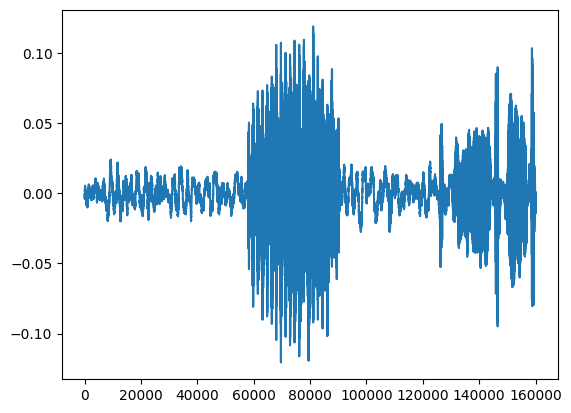

In [11]:
import matplotlib.pyplot as plt

plt.plot(waveform_batch[0])
plt.show()

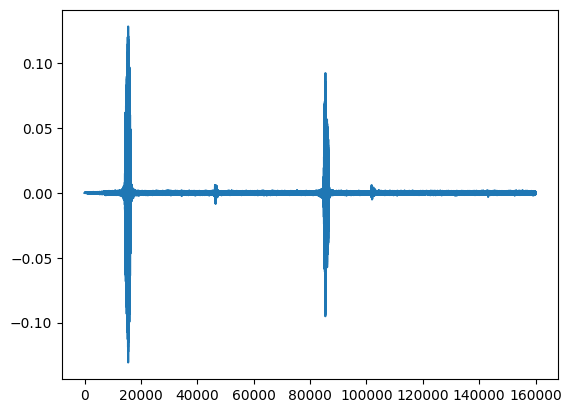

In [12]:
plt.plot(waveform_batch[1])

In [11]:
from IPython.display import Audio

# Create an Audio widget to play the first waveform in the batch
Audio(data=waveform_batch[0], rate=32000)


In [12]:
from IPython.display import Audio

# Create an Audio widget to play the first waveform in the batch
Audio(data=waveform_batch[1], rate=32000)


In [7]:
import sys
sys.path.append("..")
from transforms import DefaultFeatureExtractor

feature_extractor = DefaultFeatureExtractor(
    feature_size=1,
    sampling_rate=32_000,
    padding_value=0.0,
    return_attention_mask=False
)    

In [8]:
def process_waveforms(waveforms):
    max_length = int(int(32_000) * 5)
    waveform_batch = feature_extractor(
        waveforms,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_attention_mask=False
    )
    # add std
    waveform_batch["input_values"] = waveform_batch["input_values"] - waveform_batch["input_values"].mean(axis=1, keepdims=True) # center 0 
    return waveform_batch 

In [13]:
waveform_batch = process_waveforms(waveform_batch) 

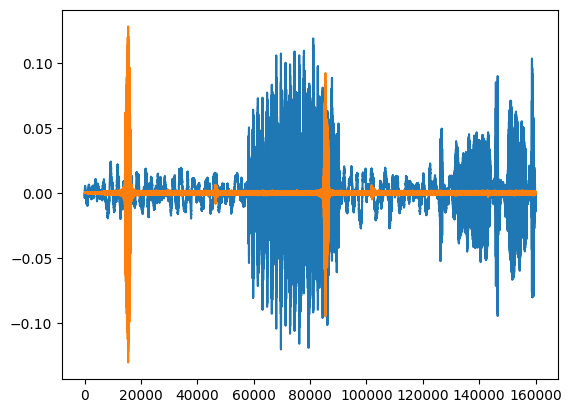

In [14]:
from matplotlib import pyplot as plt
plt.plot(waveform_batch["input_values"][0])
plt.plot(waveform_batch["input_values"][1])

In [15]:
import torch
def cyclic_rolling_start(waveforms):
    batch_size, waveform_length = waveforms.shape
    idx = torch.randint(0, waveform_length, (batch_size,), device=waveforms.device)
    arange = torch.arange(waveform_length, device=waveforms.device).unsqueeze(0).expand(batch_size, -1)
    rolled_indices = (arange + idx.unsqueeze(1)) % waveform_length
    rolled_waveforms = waveforms[torch.arange(batch_size).unsqueeze(1), rolled_indices]
    volume_mag = torch.distributions.Beta(10, 10).sample((batch_size, 1)).to(waveforms.device) + 0.5
    waveforms = rolled_waveforms * volume_mag
    
    return waveforms  

In [16]:
waveform_batch["input_values"] = cyclic_rolling_start(waveform_batch["input_values"])

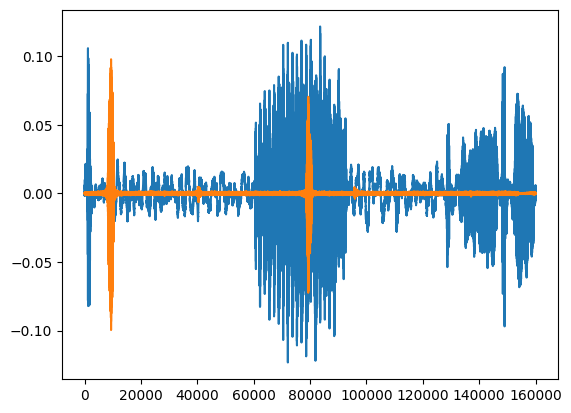

In [19]:
plt.plot(waveform_batch["input_values"][0])
plt.plot(waveform_batch["input_values"][1])

In [17]:
from torchaudio.compliance.kaldi import fbank

def compute_fbank_features(waveforms):
    fbank_features = [
        fbank(
            waveform.unsqueeze(0),
            htk_compat=True,
            sample_frequency=32_000,
            use_energy=False,
            window_type="hanning",
            num_mel_bins=128,
            dither=0.0,
            frame_shift=10
        )
        for waveform in waveforms
    ]
    return torch.stack(fbank_features)

fbank_features = compute_fbank_features(waveform_batch["input_values"])

In [18]:
fbank_features.shape

torch.Size([2, 498, 128])

In [20]:
%reload_ext autoreload
%autoreload 2
from birdset.datamodule.components.augmentations import MultilabelMix

In [79]:
from birdset.datamodule.components.augmentations import MultilabelMix
mixup_wav = MultilabelMix(p=1.0, min_snr_in_db=3.0, max_snr_in_db=30, mix_target="union", max_samples=1)

In [114]:
test = mixup_wav(waveform_batch["input_values"].unsqueeze(1)).squeeze(1)

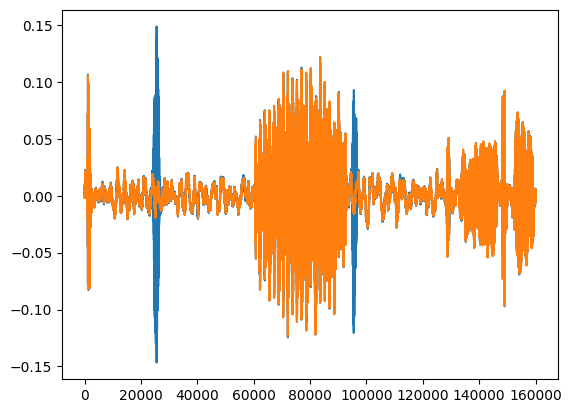

In [115]:
plt.plot(test[0])
plt.plot(waveform_batch["input_values"][0])
plt.show()

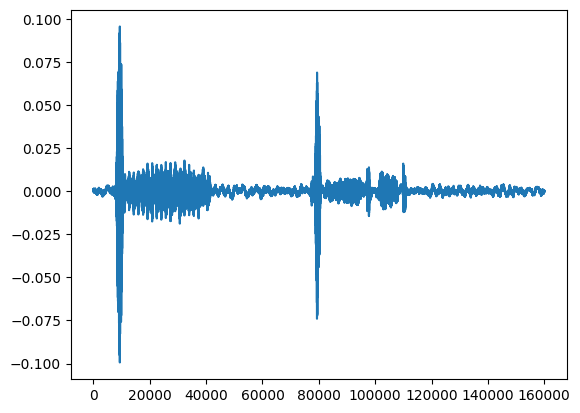

In [116]:
plt.plot(test[1])
plt.show()

In [42]:
from IPython.display import Audio

# Create an Audio widget to play the first waveform in the batch
Audio(data=test[1], rate=32000)

In [52]:
from IPython.display import Audio

# Create an Audio widget to play the first waveform in the batch
Audio(data=test[0], rate=32000)

In [21]:
from torchaudio.compliance.kaldi import fbank

def compute_fbank_features(waveforms):
    fbank_features = [
        fbank(
            waveform.unsqueeze(0),
            htk_compat=True,
            sample_frequency=32_000,
            use_energy=False,
            window_type="hanning",
            num_mel_bins=128,
            dither=0.0,
            frame_shift=10
        )
        for waveform in waveforms
    ]
    return torch.stack(fbank_features)

fbank_features_mixed = compute_fbank_features(test)

NameError: name 'test' is not defined

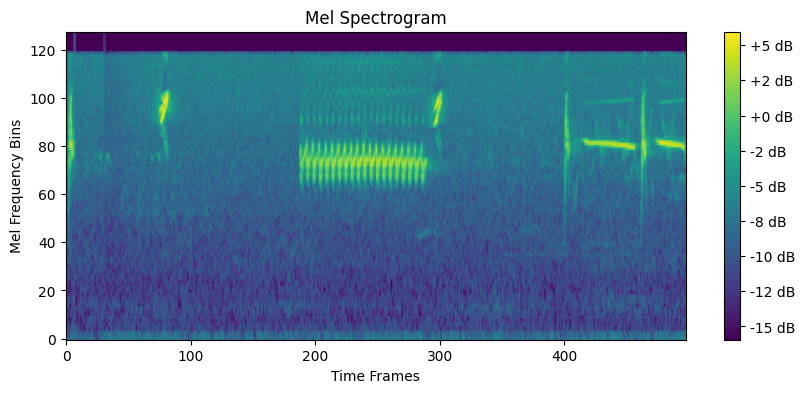

In [118]:
plt.figure(figsize=(10, 4))
plt.imshow(fbank_features_mixed[0].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')
plt.show()


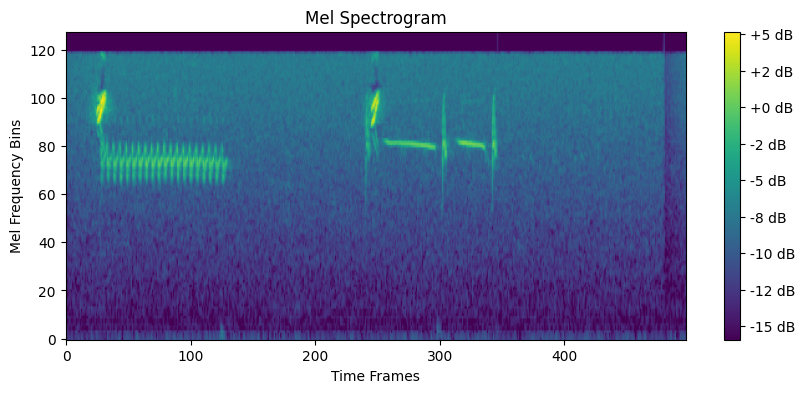

In [119]:
plt.figure(figsize=(10, 4))
plt.imshow(fbank_features_mixed[1].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')
plt.show()

In [22]:
fbank_features_notmixed = compute_fbank_features(waveform_batch["input_values"])

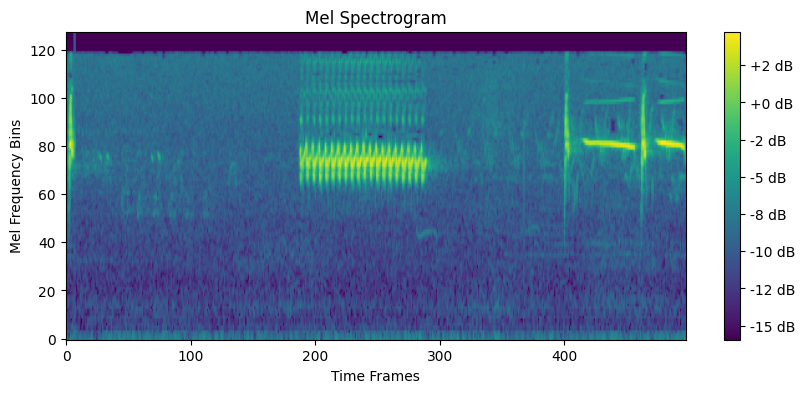

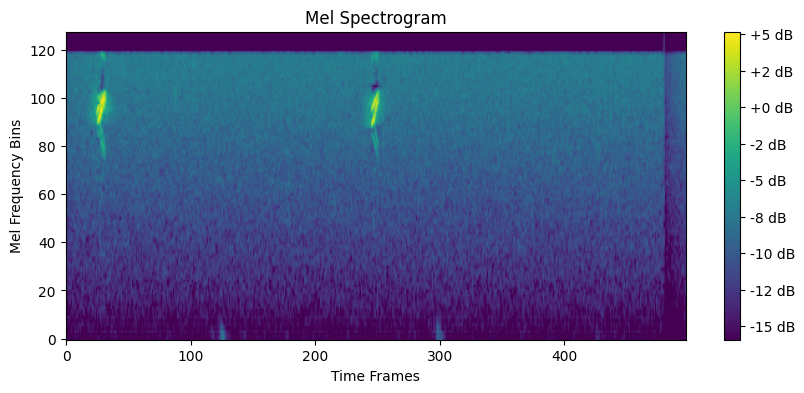

In [23]:

for i in range(2):
    plt.figure(figsize=(10, 4))
    plt.imshow(fbank_features_notmixed[i].T, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time Frames')
    plt.ylabel('Mel Frequency Bins')
    plt.show()

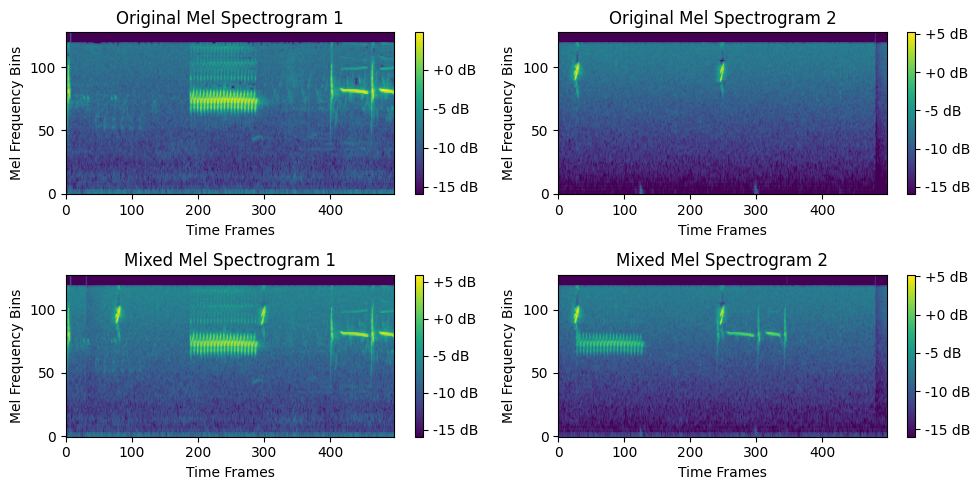

In [124]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(fbank_features_notmixed[0].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel Spectrogram 1')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.subplot(2, 2, 2)
plt.imshow(fbank_features_notmixed[1].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel Spectrogram 2')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.subplot(2, 2, 3)
plt.imshow(fbank_features_mixed[0].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mixed Mel Spectrogram 1')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.subplot(2, 2, 4)
plt.imshow(fbank_features_mixed[1].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mixed Mel Spectrogram 2')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.tight_layout()
plt.show()

In [27]:
%load_ext autoreload
%autoreload 2
from util.mixup import SpecMixup
mixup_fn = SpecMixup(
    alpha=10, 
    prob=1, 
    num_mix=2, 
    full_target=False)

fbank_features_specmixed, _ = mixup_fn(fbank_features_notmixed, batch["labels"]) # shape now: batch, 998, 128

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])
tensor([[0, 1],
        [1, 0]])


In [258]:
class SpecMixupN:
    def __init__(self, alpha=1.0, prob=1.0, num_mix=1, full_target=False, min_snr_in_db=3.0, max_snr_in_db=30.0):
        self.alpha = alpha
        self.prob = prob
        self.num_mix = num_mix
        self.full_target = full_target
        self.min_snr_in_db = min_snr_in_db
        self.max_snr_in_db = max_snr_in_db  

    def __call__(self, x, target):
        return self._mix_batch(x, target)
    
    def _mix_batch(self, x, target):
        batch_size = x.size(0)
        device = x.device
        is_waveform = len(x.shape) == 2  # True for waveforms, False for spectrograms


        snr_distribution = torch.distributions.Uniform(
            low=torch.tensor(
                self.min_snr_in_db,
                dtype=torch.float32,
                device=x.device,
            ),
            high=torch.tensor(
                self.max_snr_in_db,
                dtype=torch.float32,
                device=x.device,
            ),
            validate_args=True,
        ) # sample uniformly from this distribution (low and high values)

        # randomize SNRs
        snr = snr_distribution.sample(
            sample_shape=(batch_size,)
        )

        # Convert target to tensor if it's not already
        target = torch.tensor(target, dtype=torch.float32, device=device)

        # Generate mixing coefficients from a Dirichlet distribution
        mix_weights = torch.from_numpy(
            np.random.dirichlet([self.alpha] * self.num_mix, size=batch_size)
        ).float().to(device)

        # Generate random indices for mixing, excluding self-indices
        mix_indices = torch.empty((batch_size, self.num_mix), dtype=torch.long, device=device)
        for i in range(batch_size):
            # Create a pool of indices excluding the current index
            pool = torch.cat([torch.arange(0, i), torch.arange(i + 1, batch_size)])  # Exclude current index
            mix_indices[i] = pool[torch.randperm(batch_size - 1)[:self.num_mix]]  # Randomly select from the pool

        # Perform mixup
        #x_mix = torch.zeros_like(x)
        target_mix = target.clone()

        # Initialize x_mix with zeros or use torch.zeros_like(x) if you want to start from zero
        # x_mix = torch.zeros_like(x)  # Uncomment if you want to start from zero
        x_mix = x.clone()  # If you want to start with the original values

        batch_size, width, height = x_mix.shape

        for i in range(self.num_mix):
            if is_waveform:
                #x_mix += apply_mixup.unsqueeze(1) * mix_weights[:, i].unsqueeze(1) * x[mix_indices[:, i]]
                return
            else:
                current_indices = mix_indices[:, i]
                background_samples = rms_normalize_spectrogram(x[current_indices])

                idx = torch.randint(0, width, size=(batch_size,), device=device)  # Random starting indices for each image
                
                # Create an array of indices for the width dimension
                rolled_indices = [(torch.arange(width, device=device) + start_idx) % width for start_idx in idx]  # Roll indices for each image
                
                # Roll the images along the width dimension
                background_samples = torch.stack([background_samples[i, rolled_indices[i], :] for i in range(batch_size)])  # Shape: (batch_size, width, height)

                background_rms = calculate_rms_spectrogram(x) / (
                    10 ** (snr.unsqueeze(dim=-1) / 20)
                )
                background_rms = background_rms.unsqueeze(2).expand(-1, -1, background_samples.shape[1], -1)

                # Mix the background samples into x_mix
                x_mix += (background_rms * background_samples).sum(dim=0)
                target_mix = torch.max(target_mix, target[current_indices])
                #x_mix += apply_mixup.unsqueeze(1).unsqueeze(2) * mix_weights[:, i].unsqueeze(1).unsqueeze(2) * x[mix_indices[:, i]]

        return x_mix, target_mix.tolist()

def calculate_rms(tensor):
    return torch.sqrt(torch.mean(tensor ** 2, dim=-1, keepdim=True))

def calculate_rms_spectrogram(spectrogram):
    # Calculate RMS across the time dimension (width)
    return torch.sqrt(torch.mean(spectrogram ** 2, dim=1, keepdim=True)) 

def rms_normalize_spectrogram(samples):
    rms = samples.square().mean(dim=1, keepdim=True).sqrt()  # Shape: (batch_size, 1, height)
    return samples / (rms + 1e-8)  # Broadcasting will handle the dimensions

In [259]:

mixup_fn = SpecMixupN()

fbank_features_specmixedN, targets= mixup_fn(fbank_features_notmixed, batch["labels"]) # shape now: batch, 998, 128

In [261]:
targets[0]

[0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

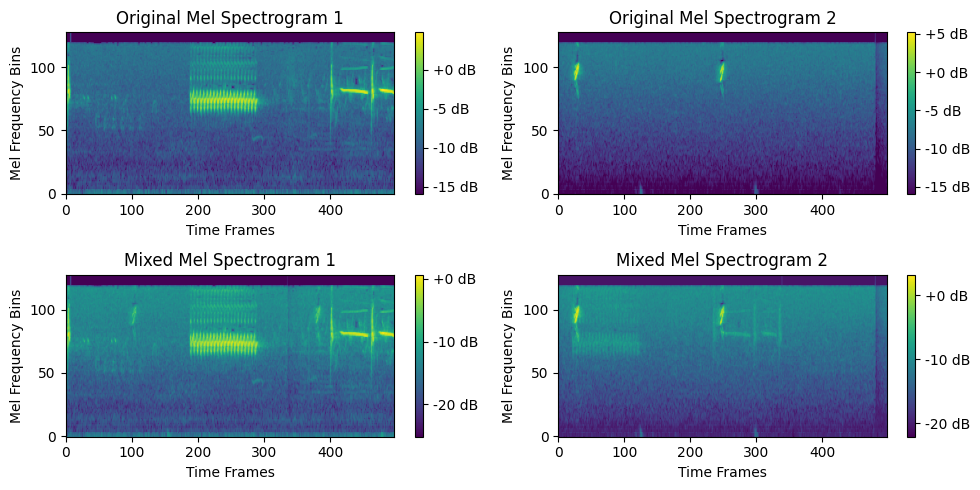

In [250]:

mixup_fn = SpecMixupN()

fbank_features_specmixedN = mixup_fn(fbank_features_notmixed, batch["labels"]) # shape now: batch, 998, 128
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(fbank_features_notmixed[0].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel Spectrogram 1')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.subplot(2, 2, 2)
plt.imshow(fbank_features_notmixed[1].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel Spectrogram 2')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.subplot(2, 2, 3)
plt.imshow(fbank_features_specmixedN[0].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mixed Mel Spectrogram 1')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.subplot(2, 2, 4)
plt.imshow(fbank_features_specmixedN[1].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mixed Mel Spectrogram 2')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.tight_layout()
plt.show()

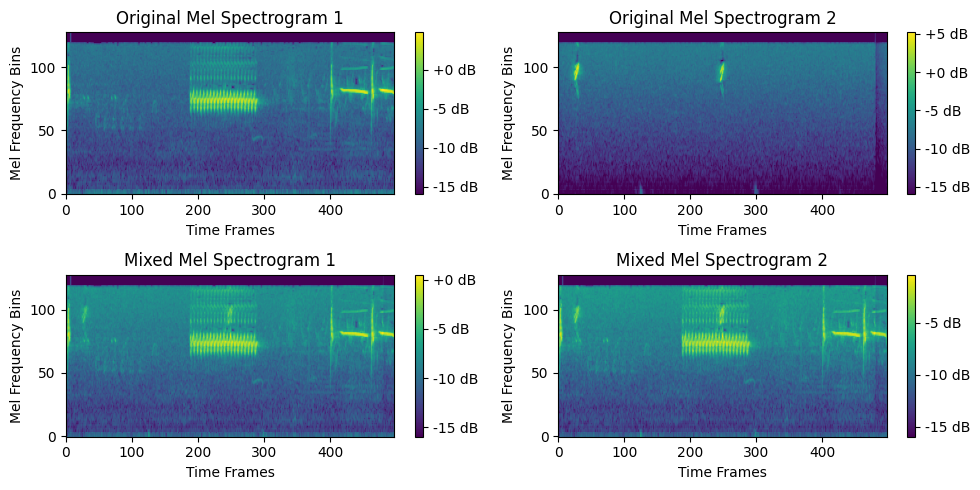

In [199]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(fbank_features_notmixed[0].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel Spectrogram 1')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.subplot(2, 2, 2)
plt.imshow(fbank_features_notmixed[1].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Mel Spectrogram 2')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.subplot(2, 2, 3)
plt.imshow(fbank_features_specmixed[0].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mixed Mel Spectrogram 1')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.subplot(2, 2, 4)
plt.imshow(fbank_features_specmixed[1].T, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mixed Mel Spectrogram 2')
plt.xlabel('Time Frames')
plt.ylabel('Mel Frequency Bins')

plt.tight_layout()
plt.show()